# Setup

In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    !apt update && apt install -y libpq-dev libsdl2-dev swig xorg-dev xvfb
    %pip install -U tf-agents pyvirtualdisplay
    %pip install -U gym>=0.21.0
    %pip install -U gym[box2d,atari,accept-rom-license]

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# To get smooth animations
import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rl"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

2021-12-05 21:23:38.826112: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-05 21:23:38.826136: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


No GPU was detected. CNNs can be very slow without a GPU.


2021-12-05 21:23:40.178384: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-05 21:23:40.178410: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-05 21:23:40.178428: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (mali-latitude7490): /proc/driver/nvidia/version does not exist


# OpenAI gym

In [52]:
import gym

In [53]:
gym.envs.registry.all()

dict_values([EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v1), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v1), EnvSpec(FrozenLake-v1), EnvSpec(FrozenLake8x8-v1), EnvSpec(CliffWalking-v0), EnvSpec(Taxi-v3), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSpec(Swimmer-v3), EnvSpec(Walker2d-v2), EnvSpec(Walker2d-v3), EnvSpec(Ant-v2), EnvSpec(Ant-v3), EnvSpec(Humanoid-v2), EnvSpec(Humanoid-v3), EnvSpec(HumanoidStandup-v2), EnvSpec(FetchSlide-v1), EnvSpec(FetchPickAndPlace-v1), EnvSpec(FetchReach-v1), EnvSpec(FetchPush-v1), EnvSpec(HandReach-v0), EnvSpec(HandManipula

In [54]:
env = gym.make('CartPole-v1')

In [55]:
env.seed(42)
obs = env.reset()

In [56]:
obs

array([-0.01258566, -0.00156614,  0.04207708, -0.00180545], dtype=float32)

In [57]:
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible = 0, size =(1400,900)).start()
except ImportError:
    pass

In [58]:
env.render()

True

In [60]:
img = env.render(mode='rgb_array')
img.shape

(400, 600, 3)

In [61]:
def plot_environment(env,figsize=(5,4)):
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    return img

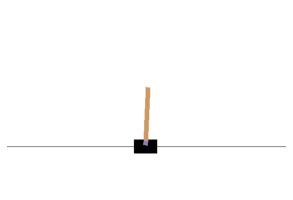

In [62]:
plot_environment(env)
plt.show()

In [63]:
env.action_space

Discrete(2)

In [64]:
action = 1
obs, reward, done, info = env.step(action)
obs

array([-0.01261699,  0.1929279 ,  0.04204097, -0.28092128], dtype=float32)

Saving figure cart_pole_plot


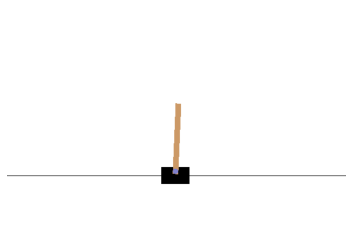

In [65]:
plot_environment(env)
save_fig('cart_pole_plot')

In [66]:
reward

1.0

In [67]:
done

False

In [68]:
info

{}

In [69]:
if done:
    obs = env.reset()

# A Simple Hard-Coded Policy

In [70]:
env.seed(42)

def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 1 else 0
    
totals = []
for episode in range(500):
    episode_reward = 0
    obs = env.reset()
    for step in range(200):
         action = basic_policy(obs)
         obs, reward, done, info = env.step(action)
         episode_reward += reward
         if done:
             break
    totals.append(episode_reward)

In [71]:
np.mean(totals) , np.std(totals), np.min(totals), np.max(totals)

(9.368, 0.7749683864519894, 8.0, 11.0)

In [72]:
env.seed(42)

frames = []

obs = env.reset()
for step in range(200):
    img = env.render(mode = 'rgb_array')
    frames.append(img)
    action = basic_policy(obs)

    obs, reward, done, info = env.step(action)
    if done:
        break

In [73]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat = False, interval = 40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = animation.FuncAnimation(
        fig, update_scene, fargs = (frames,patch),
        frames = len(frames), repeat = repeat, interval = interval)
    plt.close()
    return anim

In [74]:
plot_animation(frames)

# Neural Network Policies

In [85]:
keras.backend.clear_session()
from keras.models import Sequential
from keras.layers import Dense
tf.random.set_seed(42)
np.random.seed(42)

n_inputs = 4 # == env.observation_space[0]

model = keras.Sequential()
model.add(Dense(5, activation = 'elu', input_shape = [n_inputs]))
model.add(Dense(1, activation = 'sigmoid'))

In [87]:
def render_policy_net(model, n_max_steps = 200, seed = 42):
    frames = []
    env = gym.make('CartPole-v1')
    env.seed(seed)
    np.random.seed(seed)
    obs = env.reset()
    for step in range(n_max_steps):
        frames.append(env.render(mode='rgb_array'))
        left_proba = model.predict(obs.reshape(1,-1))
        action = int(np.random.rand() > left_proba)
        obs, reward, done, info = env.step(action)
        if done:
            break
    env.close()
    return frames

In [93]:
frames = render_policy_net(model)
plot_animation(frames)

In [121]:
n_environments = 50
n_iterations = 5000

envs = [gym.make('CartPole-v1') for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = tf.keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                            for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas,left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss,model.trainable_variables)
    optimizer.apply_gradient(zip(grads,model.trainable_variables))
    actions = (np.random.rand(n_environments,1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

    for env in envs:
        env.close()

ModuleNotFoundError: No module named 'tf'

In [122]:
n_environments = 50
n_iterations = 5000

envs = [gym.make("CartPole-v1") for _ in range(n_environments)]
for index, env in enumerate(envs):
    env.seed(index)
np.random.seed(42)
observations = [env.reset() for env in envs]
optimizer = keras.optimizers.RMSprop()
loss_fn = keras.losses.binary_crossentropy

for iteration in range(n_iterations):
    # if angle < 0, we want proba(left) = 1., or else proba(left) = 0.
    target_probas = np.array([([1.] if obs[2] < 0 else [0.])
                              for obs in observations])
    with tf.GradientTape() as tape:
        left_probas = model(np.array(observations))
        loss = tf.reduce_mean(loss_fn(target_probas, left_probas))
    print("\rIteration: {}, Loss: {:.3f}".format(iteration, loss.numpy()), end="")
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    actions = (np.random.rand(n_environments, 1) > left_probas.numpy()).astype(np.int32)
    for env_index, env in enumerate(envs):
        obs, reward, done, info = env.step(actions[env_index][0])
        observations[env_index] = obs if not done else env.reset()

for env in envs:
    env.close()

Iteration: 4999, Loss: 0.094

In [123]:
frames = render_policy_net(model)
plot_animation(frames)

# Policy Gradients